In [1]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

import pandas as pd
pd.set_option('display.max_rows',None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="pastel")

from IPython.display import Markdown, display
def printmd(string, color=None):
    string = '**' + string.replace('_',' ').title() + '**'
    display(Markdown(string))
    
import warnings
warnings.filterwarnings("ignore")

from functools import reduce

In [3]:
df = spark.read.parquet("./dataset/dataset.parquet")

In [4]:
df.registerTempTable("cus_behaviors")

In [4]:
print((df.count(), len(df.columns)))

(67501979, 9)


In [5]:
spark.sql("""
    SELECT * 
    FROM cus_behaviors 
    LIMIT 5
    ;
""").toPandas()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-17 08:43:00,view,2501799,2053013564003713919,appliances.kitchen.oven,elenberg,46.31,563237118,4368d099-6d19-47cb-95f8-1a235bc2d701
1,2019-11-17 08:43:00,view,6400335,2053013554121933129,computers.components.cpu,intel,435.28,551129779,4db2c365-ee85-4437-87ad-23d70bfc01a9
2,2019-11-17 08:43:00,view,3701538,2053013565983425517,appliances.environment.vacuum,irobot,1878.81,539845715,bf7d95c0-69e1-40ff-817b-7118652f018b
3,2019-11-17 08:43:00,view,26400266,2053013563651392361,None,lucente,119.18,572211322,8e6c63f8-7f34-48b3-a0d2-69bbcec41fa3
4,2019-11-17 08:43:00,view,1004659,2053013555631882655,electronics.smartphone,samsung,762.18,512965259,2981c9f9-3905-49de-b8db-453d5134969f


In [6]:
datatype = {}
for c,t in df.dtypes:
    if t in datatype.keys():
        datatype[t].append(c)
    else:
        datatype[t] = [c]
        
datatype.keys()

dict_keys(['timestamp', 'string', 'int', 'bigint', 'double'])

In [7]:
for key in datatype.keys():
    print(key,datatype[key])

timestamp ['event_time']
string ['event_type', 'category_code', 'brand', 'user_session']
int ['product_id', 'user_id']
bigint ['category_id']
double ['price']


In [8]:
category_cols = datatype['string'] + datatype['bigint'] + datatype['int']

In [13]:
dfs = []
for col in category_cols:
    sql_script = \
    f"""
        SELECT 
            COUNT(DISTINCT {col}) AS {col}
        FROM cus_behaviors
        ;
    """
    temp_df = query(sql_script)
    dfs.append(temp_df)

printmd('distinct category count')
count_unique_category = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True),dfs)
display(count_unique_category.T)

spark.catalog.clearCache()

**Distinct Category Count**

,0
event_type,3
category_code,129
brand,4201
user_session,13776050
category_id,684
product_id,190662
user_id,3696117


In [15]:
dfs = []
for col in category_cols:
    sql_script = \
    f"""
        SELECT
            SUM(
                CASE
                    WHEN {col} IS NULL THEN 1
                    ELSE 0
                END
            ) as {col}
        FROM cus_behaviors
    """
    temp_df = query(sql_script)
    dfs.append(temp_df)
count_null_category = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True),dfs)

dfs = []
for col in category_cols:
    sql_script = \
    f"""
        SELECT
            SUM(
                CASE
                    WHEN {col} IS NULL THEN 0
                    ELSE 1
                END
            ) as {col}
        FROM cus_behaviors
    """
    temp_df = query(sql_script)
    dfs.append(temp_df)
count_non_null_category = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True),dfs)


count_null_category = count_null_category.T
count_null_category.columns = ['null_count']
count_non_null_category = count_non_null_category.T
count_non_null_category.columns = ['non_null']
printmd('null category count')
temp = pd.merge(count_non_null_category,count_null_category,left_index=True, right_index=True)
display(temp)

spark.catalog.clearCache()

**Null Category Count**

,non_null,null_count
event_type,67501979,0
category_code,45603808,21898171
brand,58283744,9218235
user_session,67501969,10
category_id,67501979,0
product_id,67501979,0
user_id,67501979,0


**Price**

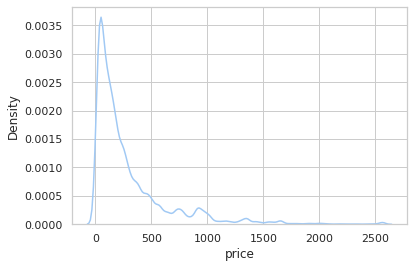

In [16]:
numeric_cols = ['price']
dfs = df.select(numeric_cols).sample(withReplacement=False, fraction=0.01, seed=None).toPandas()
for col in numeric_cols:
    printmd(col)
    sns.kdeplot(dfs[col])
    plt.show()

In [19]:
sql_script = \
"""
    SELECT 
        user_id,
        COUNT(DISTINCT user_session) AS user_session
    FROM cus_behaviors
    GROUP BY user_id
    ;
"""
num_session_by_user = query(sql_script)

printmd('number of session by user id')
display(num_session_by_user.sort_values('user_session',ascending=False).head(20))

spark.catalog.clearCache()

**Number Of Session By User Id**

,user_id,user_session
1890096,568778435,22542
3261873,569335945,14810
68473,512475445,6074
911561,568793129,4453
526892,567475167,3617
1359693,514649263,3308
3271685,568781398,3291
3231970,568804062,3290
945744,568789585,3227
3261773,568805468,2767


In [17]:
dfs = []
for col in datatype['string'][:3]:
    sql_script = \
    f"""
        SELECT 
            {col},
            COUNT({col}) AS count
        FROM cus_behaviors
        GROUP BY {col}
        ;
    """
    temp_df = query(sql_script)
    dfs.append(temp_df)
    
printmd('category elements count')
for df in dfs:
    display(df.sort_values(by='count',ascending=False))

spark.catalog.clearCache()

**Category Elements Count**

,event_type,count
1,view,63556110
2,cart,3028930
0,purchase,916939


,category_code,count
60,electronics.smartphone,16375000
77,electronics.video.tv,2208046
73,computers.notebook,2180554
53,electronics.clocks,2086966
89,apparel.shoes,1886890
9,electronics.audio.headphone,1816877
94,appliances.environment.vacuum,1528058
106,appliances.kitchen.refrigerators,1427162
122,appliances.kitchen.washer,1403866
103,computers.desktop,690502


,brand,count
1529,samsung,7889245
428,apple,6259379
2812,xiaomi,4638062
2113,huawei,1410126
1801,lucente,1185075
1331,lg,1096990
2356,bosch,975059
1157,oppo,811698
1330,sony,798457
1530,respect,765331
